In [734]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
import yaml
from pathlib import Path
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [736]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [738]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper Functions

In [5]:
## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):
    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
            nb_cwd.parents[1]  # -> git/trend_following
            / "live_strategy"
            / f"trend_following_strategy_{strategy_version}-live"
            / "config"
            / f"trend_strategy_config_{strategy_version}.yaml"
    )

    print(config_path)  # sanity check
    print(config_path.exists())  # should be True

    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

In [6]:
from collections import OrderedDict

def print_strategy_params():
    """
    Pretty-print the strategy’s configuration values, with a blank line
    separating each logical section.
    """

    # ---- Define sections (title is just for dev readability) --------------
    sections = [
        ("Dates & universe", OrderedDict([
            ("start_date",      start_date),
            ("end_date",        end_date),
            ("warm_up_days",    WARMUP_DAYS),
            ("ticker_list",     ticker_list),
        ])),

        ("Moving-average / trend", OrderedDict([
            ("fast_mavg",                  fast_mavg),
            ("slow_mavg",                  slow_mavg),
            ("mavg_stepsize",              mavg_stepsize),
            ("mavg_z_score_window",        mavg_z_score_window),
            ("moving_avg_type",            moving_avg_type),
            ("ma_crossover_signal_weight", ma_crossover_signal_weight),
        ])),

        ("Donchian channel", OrderedDict([
            ("entry_rolling_donchian_window", entry_rolling_donchian_window),
            ("exit_rolling_donchian_window", exit_rolling_donchian_window),
            ("use_donchian_exit_gate", use_donchian_exit_gate),
            ("donchian_signal_weight",  donchian_signal_weight),
        ])),

        ("Volatility & risk", OrderedDict([
            ("volatility_window",            volatility_window),
            ("annualized_target_volatility", annualized_target_volatility),
            ("rolling_cov_window",           rolling_cov_window),
            ("rolling_atr_window",           rolling_atr_window),
            ("atr_multiplier",               atr_multiplier),
            ("log_std_window",               log_std_window),
            ("coef_of_variation_window",     coef_of_variation_window),
            ("vol_of_vol_z_score_window",    vol_of_vol_z_score_window),
            ("vol_of_vol_p_min",             vol_of_vol_p_min),
            ("r2_strong_threshold",          r2_strong_threshold)
        ])),

        ("Signal gating / quality", OrderedDict([
            ("lower_r_sqr_limit",             lower_r_sqr_limit),
            ("upper_r_sqr_limit",             upper_r_sqr_limit),
            ("rolling_r2_window",             rolling_r2_window),
            ("r2_smooth_window",              r2_smooth_window),
            ("r2_confirm_days",               r2_confirm_days),
            ("rolling_sharpe_window",         rolling_sharpe_window),
            ("use_activation",                use_activation),
            ("tanh_activation_constant_dict", tanh_activation_constant_dict),
            ("weighted_signal_ewm_window",    weighted_signal_ewm_window)
        ])),

        ("Trading toggles & thresholds", OrderedDict([
            ("long_only",                  long_only),
            ("use_coinbase_data",          use_coinbase_data),
            ("use_saved_files",            use_saved_files),
            ("saved_file_end_date",        saved_file_end_date),
            ("use_specific_start_date",    use_specific_start_date),
            ("signal_start_date",          signal_start_date),
            ("price_or_returns_calc",      price_or_returns_calc),
            ("notional_threshold_pct",     notional_threshold_pct),
            ("cooldown_counter_threshold", cooldown_counter_threshold),
            ("warmup_days",                WARMUP_DAYS)
        ])),

        ("Capital & execution", OrderedDict([
            ("initial_capital",        initial_capital),
            ("cash_buffer_percentage", cash_buffer_percentage),
            ("transaction_cost_est",   transaction_cost_est),
            ("passive_trade_rate",     passive_trade_rate),
            ("annual_trading_days",    annual_trading_days),
        ])),
    ]

    # ---- Compute width for neat alignment ---------------------------------
    longest_key = max(len(k) for _, sec in sections for k in sec)

    print("\nStrategy Parameters\n" + "-" * (longest_key + 30))
    for _, sec in sections:
        for k, v in sec.items():
            print(f"{k:<{longest_key}} : {v}")
        print()  # blank line between sections
    print("-" * (longest_key + 30) + "\n")

# ---------------------------------------------------------------------------
# Example usage (uncomment after your own parameter definitions are in scope)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     print_strategy_params()

In [7]:
def plot_signal_performance(df_1, df_2, ticker):

    fig = plt.figure(figsize=(20,12))
    layout = (2,2)
    signal_ax = plt.subplot2grid(layout, (0,0))
    price_ax = signal_ax.twinx()
    equity_curve_ax = plt.subplot2grid(layout, (0,1))
    sharpe_ax = plt.subplot2grid(layout, (1,0))
    portfolio_value_ax = plt.subplot2grid(layout, (1,1))

    _ = signal_ax.plot(df_1.index, df_1[f'{ticker}_final_signal'], label='Orig Signal', alpha=0.9)
    _ = signal_ax.plot(df_2.index, df_2[f'{ticker}_final_signal'], label='New Signal', alpha=0.9)
    _ = price_ax.plot(df_1.index, df_2[f'{ticker}_open'], label='Price', alpha=0.7, linestyle='--', color='magenta')
    _ = signal_ax.set_title(f'Orignal Signal vs New Signal')
    _ = signal_ax.set_ylabel('Signal')
    _ = signal_ax.set_xlabel('Date')
    _ = signal_ax.legend(loc='upper left')
    _ = signal_ax.grid()

    _ = equity_curve_ax.plot(df_1.index, df_1[f'equity_curve'], label='Orig Signal', alpha=0.9)
    _ = equity_curve_ax.plot(df_2.index, df_2[f'equity_curve'], label='New Signal', alpha=0.9)
    _ = equity_curve_ax.set_title(f'Equity Curve')
    _ = equity_curve_ax.set_ylabel('Equity Curve')
    _ = equity_curve_ax.set_xlabel('Date')
    _ = equity_curve_ax.legend(loc='upper left')
    _ = equity_curve_ax.grid()

    _ = sharpe_ax.plot(df_1.index, df_1[f'portfolio_rolling_sharpe_50'], label='Orig Signal', alpha=0.9)
    _ = sharpe_ax.plot(df_2.index, df_2[f'portfolio_rolling_sharpe_50'], label='New Signal', alpha=0.9)
    _ = sharpe_ax.set_title(f'Rolling Sharpe')
    _ = sharpe_ax.set_ylabel(f'Rolling Sharpe')
    _ = sharpe_ax.set_xlabel('Date')
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.grid()

    _ = portfolio_value_ax.plot(df_1.index, df_1[f'total_portfolio_value'], label='Orig Signal', alpha=0.9)
    _ = portfolio_value_ax.plot(df_2.index, df_2[f'total_portfolio_value'], label='New Signal', alpha=0.9)
    _ = portfolio_value_ax.set_title(f'Total Portfolio Value')
    _ = portfolio_value_ax.set_ylabel('Portfolio Value')
    _ = portfolio_value_ax.set_xlabel('Date')
    _ = portfolio_value_ax.legend(loc='upper left')
    _ = portfolio_value_ax.grid()

    plt.tight_layout()

    return

## Signal Performance

In [15]:
cfg = load_prod_strategy_config()

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [17]:
cfg

{'portfolio': {'exchange': 'Coinbase Advanced', 'name': 'Trend Following'},
 'run': {'start_date': '2022-04-01',
  'end_date': '2025-07-31',
  'use_specific_start_date': True,
  'signal_start_date': '2022-04-01',
  'warmup_days': 300,
  'long_only': True,
  'annual_trading_days': 365,
  'initial_capital': 15000},
 'universe': {'tickers': ['BTC-USD',
   'ETH-USD',
   'SOL-USD',
   'ADA-USD',
   'AVAX-USD']},
 'data': {'use_coinbase_data': True,
  'use_saved_files': True,
  'saved_file_end_date': '2025-07-31',
  'price_or_returns_calc': 'price',
  'moving_avg_type': 'exponential'},
 'signals': {'moving_average': {'fast_mavg': 20,
   'slow_mavg': 200,
   'mavg_stepsize': 8,
   'mavg_z_score_window': 126},
  'donchian': {'entry_rolling_donchian_window': 56,
   'exit_rolling_donchian_window': 28,
   'use_donchian_exit_gate': False},
  'weighting': {'ma_crossover_signal_weight': 0.85,
   'donchian_signal_weight': 0.15,
   'weighted_signal_ewm_window': 4},
  'activation': {'use_activation': F

In [19]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

ticker_list = list(cfg['universe']['tickers'])

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [59]:
df_final_prod_config = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config = df_final_prod_config[df_final_prod_config.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config = perf.calculate_asset_level_returns(df_final_prod_config, end_date, ticker_list)

portfolio_perf_metrics_prod_config = calculate_risk_and_performance_metrics(df_final_prod_config, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                           strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2753853358168141,
 'annualized_sharpe_ratio': 1.2297193387033585,
 'calmar_ratio': 1.6289999017207646,
 'annualized_std_dev': 0.3971031922886883,
 'max_drawdown': -0.1690517817256562,
 'max_drawdown_duration': Timedelta('250 days 00:00:00'),
 'hit_rate': 0.13957307060755336,
 't_statistic': 2.771813779595924,
 'p_value': 0.0056594559018005725,
 'trade_count': 161.0}

In [91]:
ticker_perf_prod_config = {}
for t in cfg['universe']['tickers']:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config[t] = _ticker_perf

In [93]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [61]:
import pandas as pd

# assume cfg is already loaded from YAML as shown in your message

# --- Prod Configuration (from cfg) ---
start_date  = pd.Timestamp(cfg['run']['start_date']).date()
end_date    = pd.Timestamp(cfg['run']['end_date']).date()
warmup_days = int(cfg['run']['warmup_days'])

# ticker_list = list(cfg['universe']['tickers'])
ticker_list = ['BTC-USD', 'ETH-USD', 'SOL-USD', 'ADA-USD', 'AVAX-USD', 'LTC-USD', 'DOGE-USD', 'CRO-USD']

# signals.moving_average
fast_mavg        = int(cfg['signals']['moving_average']['fast_mavg'])
slow_mavg        = int(cfg['signals']['moving_average']['slow_mavg'])
mavg_stepsize    = int(cfg['signals']['moving_average']['mavg_stepsize'])
mavg_z_score_window = int(cfg['signals']['moving_average']['mavg_z_score_window'])

# signals.donchian
entry_rolling_donchian_window = int(cfg['signals']['donchian']['entry_rolling_donchian_window'])
exit_rolling_donchian_window  = int(cfg['signals']['donchian']['exit_rolling_donchian_window'])
use_donchian_exit_gate        = bool(cfg['signals']['donchian']['use_donchian_exit_gate'])

# signals.weighting
ma_crossover_signal_weight = float(cfg['signals']['weighting']['ma_crossover_signal_weight'])
donchian_signal_weight     = float(cfg['signals']['weighting']['donchian_signal_weight'])
weighted_signal_ewm_window = int(cfg['signals']['weighting']['weighted_signal_ewm_window'])  # (new config but same value)

# signals.filters.rolling_r2
rolling_r2_window   = int(cfg['signals']['filters']['rolling_r2']['rolling_r2_window'])
lower_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['lower_r_sqr_limit'])
upper_r_sqr_limit   = float(cfg['signals']['filters']['rolling_r2']['upper_r_sqr_limit'])
r2_smooth_window    = int(cfg['signals']['filters']['rolling_r2']['r2_smooth_window'])
r2_confirm_days     = int(cfg['signals']['filters']['rolling_r2']['r2_confirm_days'])
r2_strong_threshold = float(cfg['signals']['filters']['rolling_r2']['r2_strong_threshold'])

# signals.filters.vol_of_vol
log_std_window            = int(cfg['signals']['filters']['vol_of_vol']['log_std_window'])
coef_of_variation_window  = int(cfg['signals']['filters']['vol_of_vol']['coef_of_variation_window'])
vol_of_vol_z_score_window = int(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_z_score_window'])
vol_of_vol_p_min          = float(cfg['signals']['filters']['vol_of_vol']['vol_of_vol_p_min'])

# signals.activation
use_activation              = bool(cfg['signals']['activation']['use_activation'])
tanh_activation_constant_dict = cfg['signals']['activation']['tanh_activation_constant_dict']  # likely None

# data / run toggles
moving_avg_type        = str(cfg['data']['moving_avg_type'])
long_only              = bool(cfg['run']['long_only'])
price_or_returns_calc  = str(cfg['data']['price_or_returns_calc'])

initial_capital        = float(cfg['run']['initial_capital'])

rolling_cov_window     = int(cfg['risk_and_sizing']['rolling_cov_window'])
volatility_window      = int(cfg['risk_and_sizing']['volatility_window'])

# stop loss strategy (new)
stop_loss_strategy     = str(cfg['risk_and_sizing']['stop_loss_strategy'])
rolling_atr_window     = int(cfg['risk_and_sizing']['rolling_atr_window'])
atr_multiplier         = float(cfg['risk_and_sizing']['atr_multiplier'])
highest_high_window    = int(cfg['risk_and_sizing']['highest_high_window'])

# cooldown (new)
cooldown_counter_threshold = int(cfg['execution_and_costs']['cooldown_counter_threshold'])

# target vol (new value)
annualized_target_volatility = float(cfg['risk_and_sizing']['annualized_target_volatility'])

transaction_cost_est   = float(cfg['execution_and_costs']['transaction_cost_est'])
passive_trade_rate     = float(cfg['execution_and_costs']['passive_trade_rate'])
notional_threshold_pct = float(cfg['execution_and_costs']['notional_threshold_pct'])

rolling_sharpe_window  = int(cfg['risk_and_sizing']['rolling_sharpe_window'])
cash_buffer_percentage = float(cfg['risk_and_sizing']['cash_buffer_percentage'])
annual_trading_days    = int(cfg['run']['annual_trading_days'])

use_coinbase_data      = bool(cfg['data']['use_coinbase_data'])
use_saved_files        = bool(cfg['data']['use_saved_files'])
saved_file_end_date    = str(cfg['data']['saved_file_end_date'])

use_specific_start_date = bool(cfg['run']['use_specific_start_date'])
signal_start_date       = pd.Timestamp(cfg['run']['signal_start_date']).date()


In [63]:
df_final_prod_config_expanded = tf.apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
    start_date=start_date - pd.Timedelta(days=warmup_days), end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window, 
    entry_rolling_donchian_window=entry_rolling_donchian_window, exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate, 
    ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight, weighted_signal_ewm_window=weighted_signal_ewm_window,
    rolling_r2_window=rolling_r2_window, lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window, r2_confirm_days=r2_confirm_days,
    log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window, vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min, r2_strong_threshold=r2_strong_threshold,
    use_activation=use_activation, tanh_activation_constant_dict=tanh_activation_constant_dict,
    moving_avg_type=moving_avg_type, long_only=long_only, price_or_returns_calc=price_or_returns_calc,
    initial_capital=initial_capital, rolling_cov_window=rolling_cov_window, volatility_window=volatility_window,
    rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
    transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
    notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
    use_coinbase_data=use_coinbase_data, use_saved_files=False, saved_file_end_date=saved_file_end_date, 
    rolling_sharpe_window=rolling_sharpe_window, cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
    annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date, signal_start_date=start_date)
df_final_prod_config_expanded = df_final_prod_config_expanded[df_final_prod_config_expanded.index >= pd.Timestamp(start_date).date()]

print('Calculating In Sample Asset Returns!!')
df_final_prod_config_expanded = perf.calculate_asset_level_returns(df_final_prod_config_expanded, end_date, ticker_list)

portfolio_perf_metrics_prod_config_expanded = calculate_risk_and_performance_metrics(df_final_prod_config_expanded, strategy_daily_return_col=f'portfolio_daily_pct_returns',
                                                                                     strategy_trade_count_col=f'count_of_positions', include_transaction_costs_and_fees=False, passive_trade_rate=0.05, annual_trading_days=365, transaction_cost_est=0.001)
portfolio_perf_metrics_prod_config_expanded

Generating Moving Average Ribbon Signal!!
Generating Volatility Adjusted Trend Signal!!
Getting Average True Range for Stop Loss Calculation!!
Calculating Volatility Targeted Position Size and Cash Management!!
Calculating Portfolio Performance!!
Calculating In Sample Asset Returns!!


{'annualized_return': 0.2663882716096857,
 'annualized_sharpe_ratio': 1.1408221947783335,
 'calmar_ratio': 1.6380227916339998,
 'annualized_std_dev': 0.3998958458850229,
 'max_drawdown': -0.1626279395929233,
 'max_drawdown_duration': Timedelta('302 days 00:00:00'),
 'hit_rate': 0.14203612479474548,
 't_statistic': 2.585166808646033,
 'p_value': 0.009848655615997258,
 'trade_count': 191.0}

In [95]:
ticker_perf_prod_config_expanded = {}
for t in ticker_list:
    _ticker_perf = perf.calculate_risk_and_performance_metrics(
        df_final_prod_config_expanded,
        strategy_daily_return_col=f'{t}_daily_pct_returns',
        strategy_trade_count_col=f'{t}_position_count',
        annual_trading_days=365,
        include_transaction_costs_and_fees=False
    )
    ticker_perf_prod_config_expanded[t] = _ticker_perf

In [119]:
ticker_perf_prod_config

{'BTC-USD': {'annualized_return': 0.06982390814356143,
  'annualized_sharpe_ratio': 0.26244384664420484,
  'calmar_ratio': 0.8416927133190821,
  'annualized_std_dev': 0.20587347542227852,
  'max_drawdown': -0.08295653156865514,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08374384236453201,
  't_statistic': 1.5318381374949266,
  'p_value': 0.1258222726952903,
  'trade_count': 205},
 'ETH-USD': {'annualized_return': 0.09196577667156114,
  'annualized_sharpe_ratio': 0.5566946293876285,
  'calmar_ratio': 0.8348031596554858,
  'annualized_std_dev': 0.2066495900046399,
  'max_drawdown': -0.1101646245679214,
  'max_drawdown_duration': Timedelta('507 days 00:00:00'),
  'hit_rate': 0.07307060755336617,
  't_statistic': 2.198078136774348,
  'p_value': 0.02813131205776444,
  'trade_count': 159},
 'SOL-USD': {'annualized_return': 0.048825027271480304,
  'annualized_sharpe_ratio': 0.014825603198136366,
  'calmar_ratio': 1.6743726653658395,
  'annualized_std_dev': 0.36

In [97]:
ticker_perf_prod_config_expanded

{'BTC-USD': {'annualized_return': 0.02819481992889794,
  'annualized_sharpe_ratio': -0.36023302367543375,
  'calmar_ratio': 0.4139334872850315,
  'annualized_std_dev': 0.1324385206522665,
  'max_drawdown': -0.06811437294872255,
  'max_drawdown_duration': Timedelta('251 days 00:00:00'),
  'hit_rate': 0.08292282430213464,
  't_statistic': 0.986533175399649,
  'p_value': 0.3240676342271769,
  'trade_count': 204},
 'ETH-USD': {'annualized_return': 0.0905609163705201,
  'annualized_sharpe_ratio': 0.5535322626099464,
  'calmar_ratio': 0.9223149911448054,
  'annualized_std_dev': 0.2164040958533258,
  'max_drawdown': -0.09818870693851907,
  'max_drawdown_duration': Timedelta('502 days 00:00:00'),
  'hit_rate': 0.06239737274220033,
  't_statistic': 2.2276002092475284,
  'p_value': 0.02608945816384652,
  'trade_count': 136},
 'SOL-USD': {'annualized_return': 0.03756453262660142,
  'annualized_sharpe_ratio': -0.1679428489151424,
  'calmar_ratio': 1.2220938015775438,
  'annualized_std_dev': 0.4280

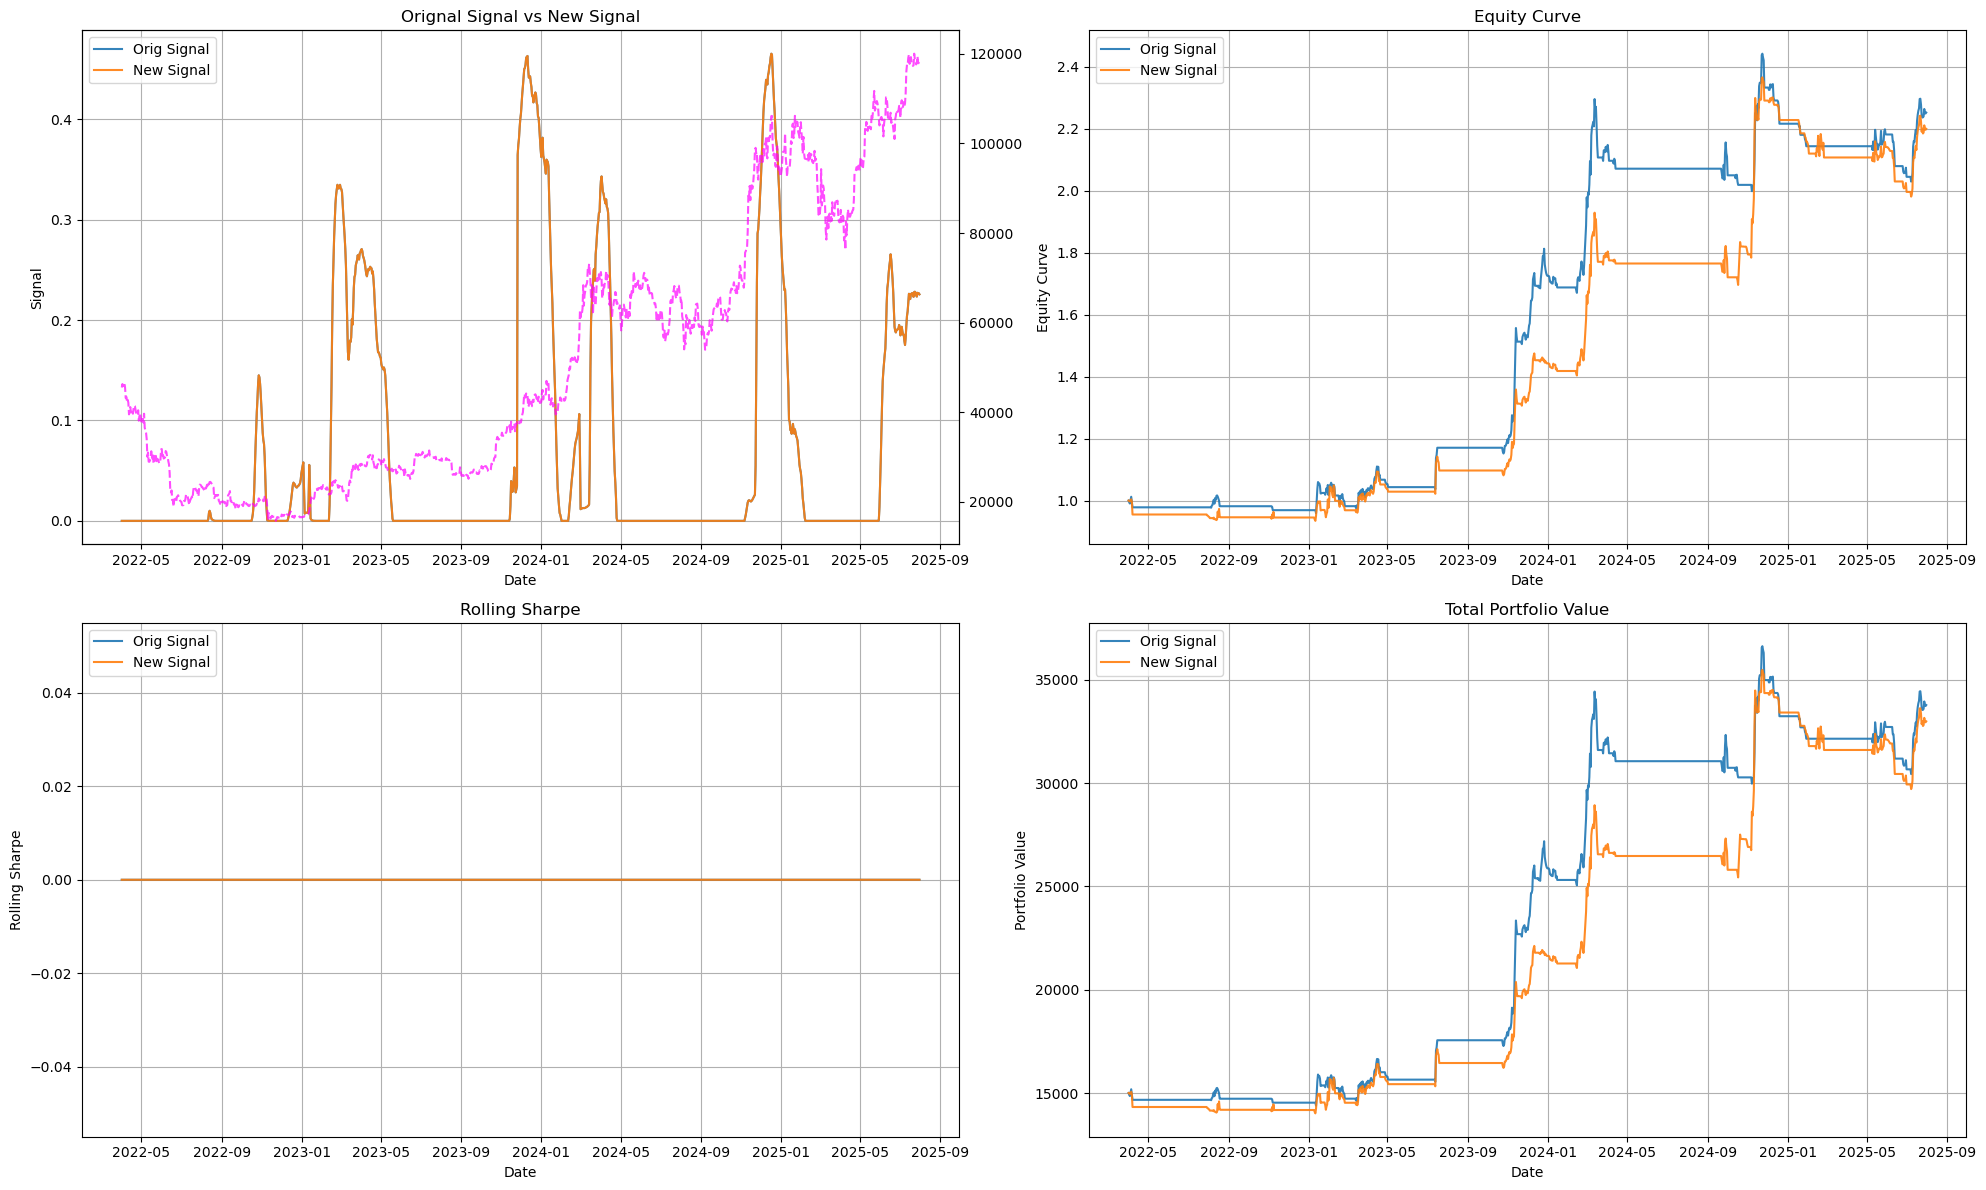

In [75]:
plot_signal_performance(df_1=df_final_prod_config, df_2=df_final_prod_config_expanded, ticker='BTC-USD')

In [65]:
df_final_prod_config_expanded.head()

,BTC-USD_20_avg_true_range_price,BTC-USD_actual_position_notional,BTC-USD_actual_position_size,BTC-USD_annualized_volatility_30,BTC-USD_close,BTC-USD_cooldown_counter,BTC-USD_event,BTC-USD_final_signal,BTC-USD_final_weighted_additive_signal,BTC-USD_highest_high_56,BTC-USD_lowest_low_56,BTC-USD_new_position_entry_exit_price,BTC-USD_new_position_notional,BTC-USD_new_position_size,BTC-USD_open,BTC-USD_open_position_notional,BTC-USD_open_position_size,BTC-USD_short_sale_proceeds,BTC-USD_stop_loss,BTC-USD_stopout_flag,BTC-USD_t_1_close,BTC-USD_t_1_close_pct_returns,BTC-USD_target_notional,BTC-USD_target_size,BTC-USD_target_vol_normalized_weight,BTC-USD_vol_adjusted_trend_signal,ETH-USD_20_avg_true_range_price,ETH-USD_actual_position_notional,ETH-USD_actual_position_size,ETH-USD_annualized_volatility_30,ETH-USD_close,ETH-USD_cooldown_counter,ETH-USD_event,ETH-USD_final_signal,ETH-USD_final_weighted_additive_signal,ETH-USD_highest_high_56,ETH-USD_lowest_low_56,ETH-USD_new_position_entry_exit_price,ETH-USD_new_position_notional,ETH-USD_new_position_size,ETH-USD_open,ETH-USD_open_position_notional,ETH-USD_open_position_size,ETH-USD_short_sale_proceeds,ETH-USD_stop_loss,ETH-USD_stopout_flag,ETH-USD_t_1_close,ETH-USD_t_1_close_pct_returns,ETH-USD_target_notional,ETH-USD_target_size,ETH-USD_target_vol_normalized_weight,ETH-USD_vol_adjusted_trend_signal,SOL-USD_20_avg_true_range_price,SOL-USD_actual_position_notional,SOL-USD_actual_position_size,SOL-USD_annualized_volatility_30,SOL-USD_close,SOL-USD_cooldown_counter,SOL-USD_event,SOL-USD_final_signal,SOL-USD_final_weighted_additive_signal,SOL-USD_highest_high_56,SOL-USD_lowest_low_56,SOL-USD_new_position_entry_exit_price,SOL-USD_new_position_notional,SOL-USD_new_position_size,SOL-USD_open,SOL-USD_open_position_notional,SOL-USD_open_position_size,SOL-USD_short_sale_proceeds,SOL-USD_stop_loss,SOL-USD_stopout_flag,SOL-USD_t_1_close,SOL-USD_t_1_close_pct_returns,SOL-USD_target_notional,SOL-USD_target_size,SOL-USD_target_vol_normalized_weight,SOL-USD_vol_adjusted_trend_signal,ADA-USD_20_avg_true_range_price,ADA-USD_actual_position_notional,ADA-USD_actual_position_size,ADA-USD_annualized_volatility_30,ADA-USD_close,ADA-USD_cooldown_counter,ADA-USD_event,ADA-USD_final_signal,ADA-USD_final_weighted_additive_signal,ADA-USD_highest_high_56,ADA-USD_lowest_low_56,ADA-USD_new_position_entry_exit_price,ADA-USD_new_position_notional,ADA-USD_new_position_size,ADA-USD_open,ADA-USD_open_position_notional,ADA-USD_open_position_size,ADA-USD_short_sale_proceeds,ADA-USD_stop_loss,ADA-USD_stopout_flag,ADA-USD_t_1_close,ADA-USD_t_1_close_pct_returns,ADA-USD_target_notional,ADA-USD_target_size,ADA-USD_target_vol_normalized_weight,ADA-USD_vol_adjusted_trend_signal,AVAX-USD_20_avg_true_range_price,AVAX-USD_actual_position_notional,AVAX-USD_actual_position_size,AVAX-USD_annualized_volatility_30,AVAX-USD_close,AVAX-USD_cooldown_counter,AVAX-USD_event,AVAX-USD_final_signal,AVAX-USD_final_weighted_additive_signal,AVAX-USD_highest_high_56,AVAX-USD_lowest_low_56,AVAX-USD_new_position_entry_exit_price,AVAX-USD_new_position_notional,AVAX-USD_new_position_size,AVAX-USD_open,AVAX-USD_open_position_notional,AVAX-USD_open_position_size,AVAX-USD_short_sale_proceeds,AVAX-USD_stop_loss,AVAX-USD_stopout_flag,AVAX-USD_t_1_close,AVAX-USD_t_1_close_pct_returns,AVAX-USD_target_notional,AVAX-USD_target_size,AVAX-USD_target_vol_normalized_weight,AVAX-USD_vol_adjusted_trend_signal,LTC-USD_20_avg_true_range_price,LTC-USD_actual_position_notional,LTC-USD_actual_position_size,LTC-USD_annualized_volatility_30,LTC-USD_close,LTC-USD_cooldown_counter,LTC-USD_event,LTC-USD_final_signal,LTC-USD_final_weighted_additive_signal,LTC-USD_highest_high_56,LTC-USD_lowest_low_56,LTC-USD_new_position_entry_exit_price,LTC-USD_new_position_notional,LTC-USD_new_position_size,LTC-USD_open,LTC-USD_open_position_notional,LTC-USD_open_position_size,LTC-USD_short_sale_proceeds,LTC-USD_stop_loss,LTC-USD_stopout_flag,LTC-USD_t_1_close,LTC-USD_t_1_close_pct_returns,LT

<Axes: xlabel='date'>

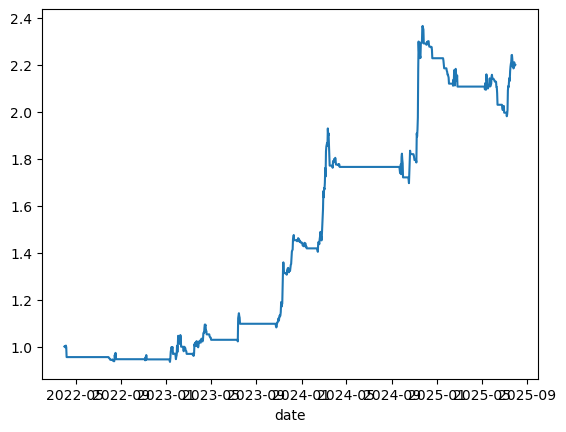

In [73]:
df_final_prod_config_expanded['equity_curve'].plot()

<Axes: xlabel='date'>

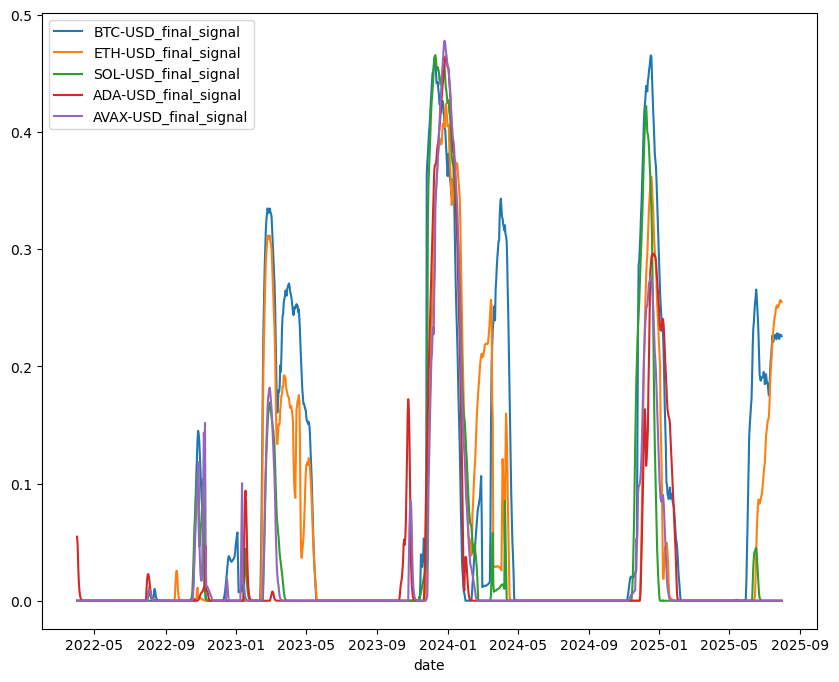

In [103]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
df_final_prod_config[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

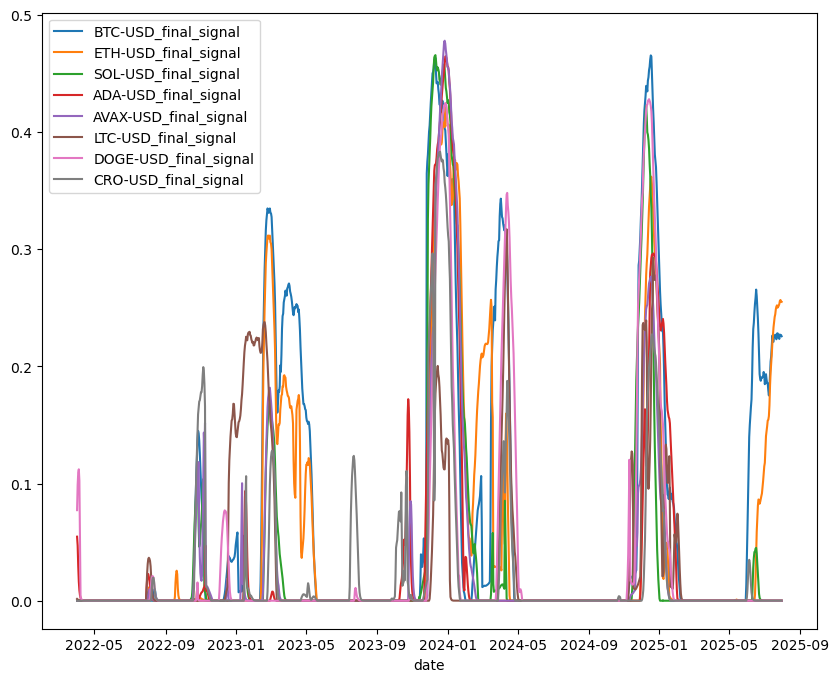

In [105]:
final_signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df_final_prod_config_expanded[final_signal_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

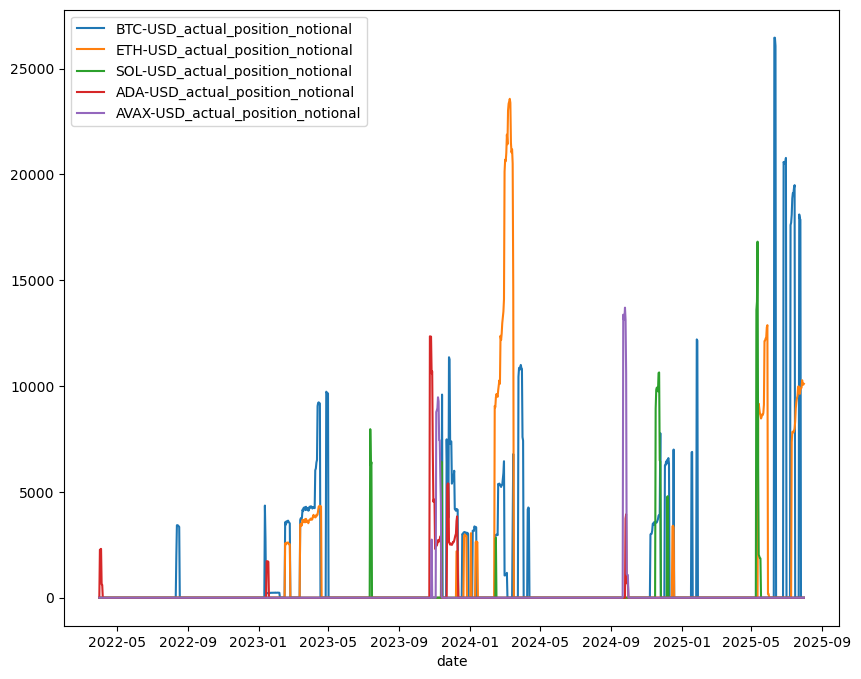

In [111]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in cfg['universe']['tickers']]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

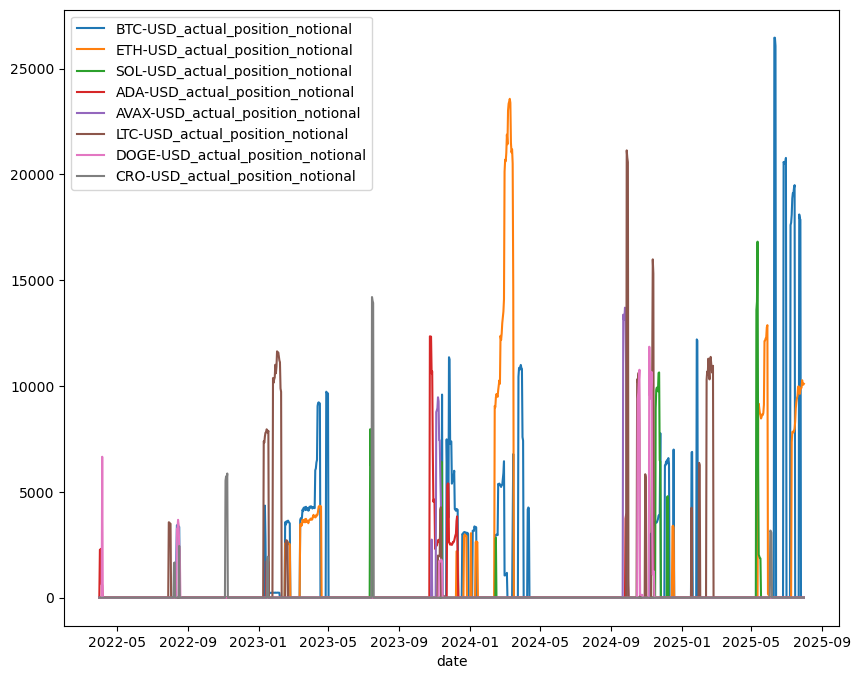

In [109]:
return_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

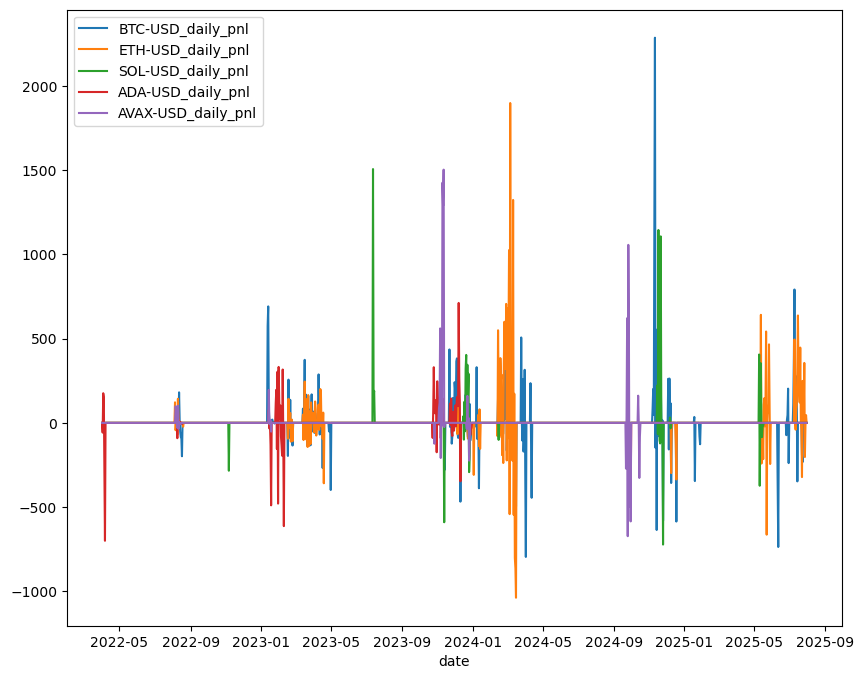

In [117]:
return_cols = [f'{ticker}_daily_pnl' for ticker in cfg['universe']['tickers']]
df_final_prod_config[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

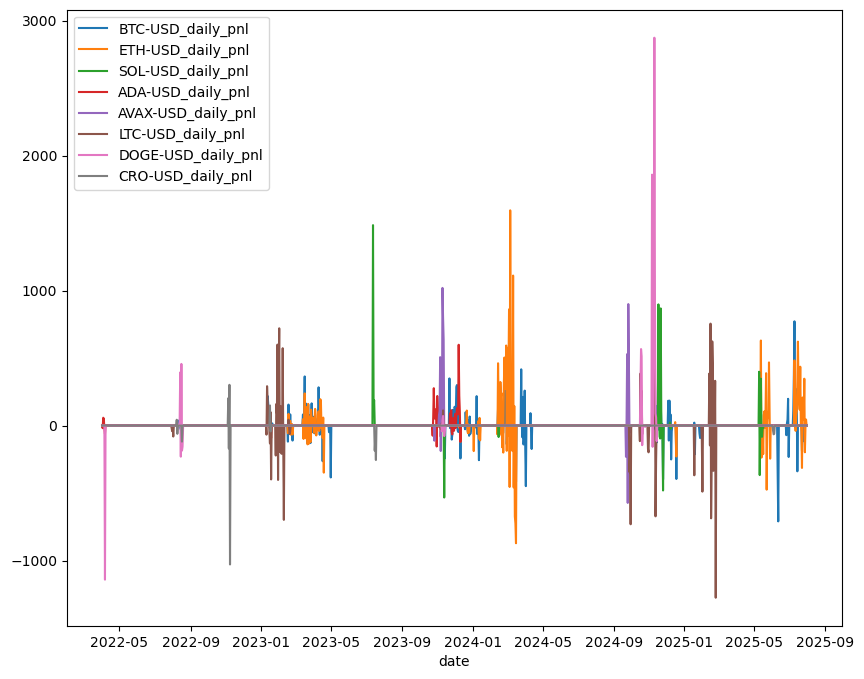

In [115]:
return_cols = [f'{ticker}_daily_pnl' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

<Axes: xlabel='date'>

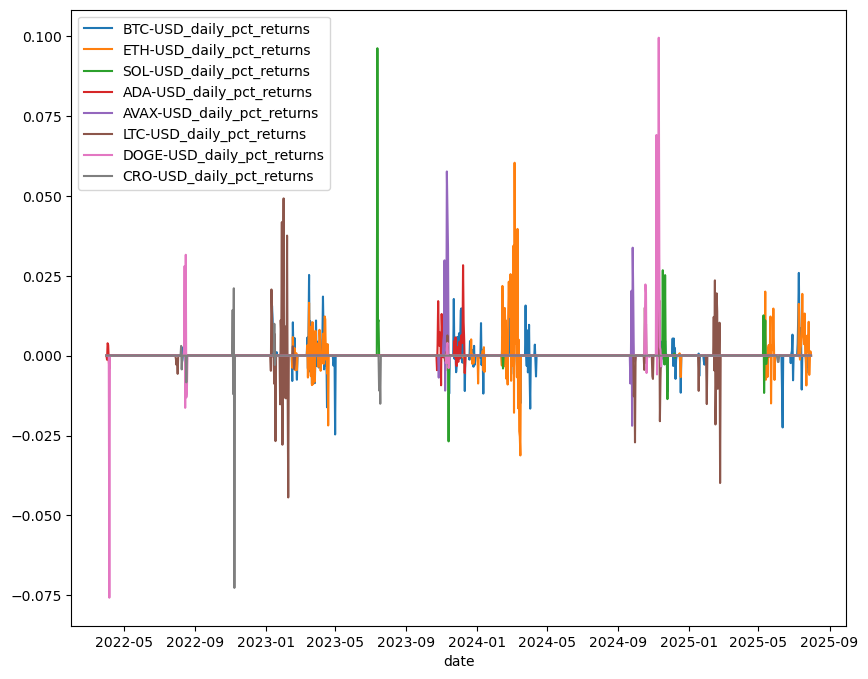

In [113]:
return_cols = [f'{ticker}_daily_pct_returns' for ticker in ticker_list]
df_final_prod_config_expanded[return_cols].plot(figsize=(10, 8))

## Get a list of all tradeable coins from Coinbase on any given day

In [756]:
def product_to_dict(p):
    # Pydantic v2
    fn = getattr(p, "model_dump", None)
    if callable(fn):
        return fn(exclude_none=True)  # or fn() if you want Nones

    # Pydantic v1
    fn = getattr(p, "dict", None)
    if callable(fn):
        return fn()

    # JSON fallbacks (v2 and v1 respectively)
    fn = getattr(p, "model_dump_json", None)
    if callable(fn):
        return json.loads(p.model_dump_json())
    fn = getattr(p, "json", None)
    if callable(fn):
        return json.loads(p.json())

    # Last-resort: plain object
    if hasattr(p, "__dict__"):
        return {k: v for k, v in vars(p).items() if not k.startswith("_")}

    return {"raw": str(p)}

In [758]:
## Get a snapshot of all the available coins to trade
CANON_QUOTE = "USD"
PRODUCTS_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)
LIQUIDITY_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/liquidity")
LIQUIDITY_DIR.mkdir(parents=True, exist_ok=True)
ELIGIBLE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/data_folder/universe/eligible_products")
ELIGIBLE_DIR.mkdir(parents=True, exist_ok=True)

def coinbase_product_snapshot(client, asof=None, save=True):

    asof = asof or datetime.now(timezone.utc).date().isoformat()
    prod = client.get_products()['products']
    rows = [product_to_dict(p) for p in prod]
    df = pd.json_normalize(rows)

    # optional: keep only columns you care about
    reqd_cols = [
        "product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
        "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
    ]
    df = df[reqd_cols]

    # optional: coerce numerics
    num_cols = ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
                "price","approximate_quote_24h_volume"]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"]) &
        (~df["is_disabled"]) &
        (~df["view_only"]) &
        (~df["cancel_only"]) &
        (~df["auction_mode"])
    )
    df = df[filt]

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}_prod.parquet"
        df.to_parquet(out, index=False)

    return df

In [552]:
def products_diff(prev_path, curr_path):
    
    prev = pd.read_parquet(prev_path)
    curr = pd.read_parquet(curr_path)
    prev_set = set(prev["ticker"])
    curr_set = set(curr["ticker"])
    adds = sorted(list(curr_set - prev_set))
    drops = sorted(list(prev_set - curr_set))
    
    return {"adds": adds, "drops": drops}

In [742]:
## Get OHLC data for each coin
def get_coinbase_candle_data(client, product_id, start_date, end_date):
    """Return a daily OHLCV DataFrame indexed by date. Empty DF if no data."""

    start_date = pd.Timestamp(start_date)
    end_date   = pd.Timestamp(end_date)
    start_timestamp = int(pd.Timestamp(start_date).timestamp())
    end_timestamp = int(pd.Timestamp(end_date).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity='ONE_DAY',
    )
    candles = resp.candles or []

    if not candles:
        # return an empty frame with the expected schema
        cols = ['low','high','open','close','volume']
        return pd.DataFrame(columns=cols).astype({c:'float64' for c in cols})

    rows = [{
        'date':   c['start'],
        'low':    float(c['low']),
        'high':   float(c['high']),
        'open':   float(c['open']),
        'close':  float(c['close']),
        'volume': float(c['volume']),
    } for c in candles]

    df = pd.DataFrame(rows)
    df['date'] = pd.to_datetime(pd.to_numeric(df['date'], errors='coerce'), unit='s', utc=True).dt.date
    return df.sort_values('date').set_index('date')

In [744]:
## Check if enough history is available and if the liquidity metrics meet all required thresholds
def has_warmup_coverage(client, product_id: str, asof_date, warmup_days: int) -> bool:
    """
    Return True if there is at least one daily candle on or before (asof - warmup_days),
    using a tiny 1-day query window.
    """
    # asof_date can be 'YYYY-MM-DD', date, or datetime
    asof = pd.Timestamp(asof_date).date()

    # boundary day at 00:00:00 UTC
    start = asof - pd.Timedelta(days=warmup_days)
    end   = start + pd.Timedelta(days=1)
    start_timestamp = int(pd.Timestamp(start).timestamp())
    end_timestamp = int(pd.Timestamp(end).timestamp())

    resp = client.get_candles(
        product_id=product_id,
        start=start_timestamp,
        end=end_timestamp,
        granularity="ONE_DAY",   # required enum value
    )
    candles = getattr(resp, "candles", []) or []
    return bool(candles)


def get_liquidity_metrics(client, product_id, asof_date, lookback_day_count=90):
    
    end_date = pd.Timestamp(asof_date).date()
    start_date = end_date - pd.Timedelta(days=lookback_day_count)
    df = get_coinbase_candle_data(client, product_id=product_id, start_date=start_date, end_date=end_date)
    df['notional_usd'] = df['volume'] * df['close']
    df['adv_90d_median'] = df['notional_usd'].rolling(90).median()
    df['high_low_spread_bps'] = (df['high'] - df['low']) / ((df['high'] + df['low']) / 2) * 10000
    df['high_low_spread_90d_median'] = df['high_low_spread_bps'].rolling(90).median()

    return df

In [802]:
## Get liquidity metrics for all coins
def get_liquidity_metrics_all_tickers(client, product_id_list, asof_date, lookback_day_count=90, warmup_days=300, save=True):

    df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
    
    for product_id in product_id_list:
        try:
            df = get_liquidity_metrics(client, product_id, asof_date=asof_date, lookback_day_count=lookback_day_count)
            row = {
                'asof_date': asof_date,
                'product_id': product_id,
                'adv_90d_median': df.loc[pd.Timestamp(asof_date).date()]['adv_90d_median'],
                'high_low_spread_90d_median': df.loc[pd.Timestamp(asof_date).date()]['high_low_spread_90d_median'],
                'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=asof_date, warmup_days=warmup_days)
            }
            df_liquidity.loc[df_liquidity.shape[0]] = row
        except KeyError:
            continue

    if save:
        out = LIQUIDITY_DIR / f"{asof_date}_liquidity.parquet"
        df_liquidity.to_parquet(out, index=False)

    return df_liquidity

In [798]:
## Get a list of all eligible coins from all the coins based on liquidity requirements
def get_eligible_ticker_list(df, asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                             warmup_days_col='warmup_days_available', adv_quantile_threshold=0.60, high_low_quantile_threshold=0.60, save=True):

    ## Get ADV Floor
    adv_null_cond = (df[median_adv_col].notnull())
    adv_usd_floor = np.quantile(df[adv_null_cond][median_adv_col], q=adv_quantile_threshold)

    ## Get High-Low Spread Floor
    high_low_null_cond = (df[median_high_low_spread_col].notnull())
    high_low_spread_floor = np.quantile(df[high_low_null_cond][median_high_low_spread_col], q=high_low_quantile_threshold)

    ## Exclude Stablecoins
    exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

    ## Create eligibility criteria
    eligible_cond = (
        (df[warmup_days_col]) &
        (df[median_adv_col] >= adv_usd_floor) &
        (df[median_high_low_spread_col] <= high_low_spread_floor) &
        (~df['product_id'].isin(exclusions))
    )

    ## Create eligibility ticker list
    df_eligible = df[eligible_cond].reset_index(drop=True)

    if save:
        out = ELIGIBLE_DIR / f"{asof_date}_eligible.parquet"
        df_eligible.to_parquet(out, index=False)

    return df_eligible, adv_usd_floor, high_low_spread_floor

In [716]:
asof_date = pd.Timestamp('2025-10-24').date()
lookback_day_count = 90
warmup_days = cfg['run']['warmup_days']
client = cn.get_coinbase_rest_api_client(portfolio_name='Default')

In [638]:
df_products_t_1 = coinbase_product_snapshot(client, asof=pd.Timestamp('2025-10-23').date(), save=True)

In [639]:
df_products = coinbase_product_snapshot(client, asof=asof_date, save=True)

In [640]:
df_products.shape

(336, 25)

In [642]:
df_products_curr = pd.read_parquet(curr_product_path)

In [643]:
df_products_curr.shape

(336, 25)

In [646]:
len(curr_product_list)

336

In [708]:
df_products_curr

,product_id,base_currency_id,quote_currency_id,product_type,status,trading_disabled,is_disabled,cancel_only,limit_only,post_only,auction_mode,view_only,base_increment,quote_increment,price_increment,base_min_size,quote_min_size,alias,alias_to,display_name,product_venue,new_at,price,approximate_quote_24h_volume,asof_date
0,BTC-USD,BTC,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,1.000000e-02,1.000000e-02,1.000000e-08,1.0,,[BTC-USDC],BTC-USD,CBE,2023-01-01T00:00:00Z,1.114960e+05,1.728954e+08,2025-10-24
1,XRP-USD,XRP,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-06,1.000000e-04,1.000000e-04,1.000000e-06,1.0,,[XRP-USDC],XRP-USD,CBE,2023-07-13T19:47:00.692Z,2.592800e+00,1.038643e+08,2025-10-24
2,ETH-USD,ETH,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,1.000000e-02,1.000000e-02,1.000000e-08,1.0,,[ETH-USDC],ETH-USD,CBE,2023-01-01T00:00:00Z,3.951950e+03,9.692119e+07,2025-10-24
3,SOL-USD,SOL,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,1.000000e-02,1.000000e-02,1.000000e-08,1.0,,[SOL-USDC],SOL-USD,CBE,2023-01-01T00:00:00Z,1.944300e+02,5.612800e+07,2025-10-24
4,CLANKER-USD,CLANKER,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-04,1.000000e-02,1.000000e-02,1.000000e-04,1.0,,[CLANKER-USDC],CLANKER-USD,CBE,2025-04-22T16:25:00.031Z,1.099800e+02,3.104877e+07,2025-10-24
5,AVNT-USD,AVNT,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-01,1.000000e-04,1.000000e-04,1.000000e-01,1.0,,[AVNT-USDC],AVNT-USD,CBE,2025-09-09T16:31:00.010Z,7.765000e-01,2.537967e+07,2025-10-24
6,ZEC-USD,ZEC,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-05,1.000000e-02,1.000000e-02,1.000000e-05,1.0,,[ZEC-USDC],ZEC-USD,CBE,2023-01-01T00:00:00Z,2.774200e+02,1.681458e+07,2025-10-24
7,SUI-USD,SUI,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-01,1.000000e-04,1.000000e-04,1.000000e-01,1.0,,[SUI-USDC],SUI-USD,CBE,2023-05-17T15:54:00.704Z,2.530600e+00,1.106698e+07,2025-10-24
8,DOGE-USD,DOGE,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-01,1.000000e-05,1.000000e-05,1.000000e-01,1.0,,[DOGE-USDC],DOGE-USD,CBE,2023-01-01T00:00:00Z,1.968400e-01,1.099719e+07,2025-10-24
9,USDT-USD,USDT,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-02,1.000000e-05,1.000000e-05,1.000000e-02,1.0,,[],USDT-USD,CBE,2023-01-01T00:00:00Z,1.000310e+00,1.013452e+07,2025-10-24


In [718]:
%%time
df_liquidity_ticker = get_liquidity_metrics_all_tickers(client, product_id_list=curr_product_list, asof_date=asof_date,
                                                        lookback_day_count=lookback_day_count, warmup_days=warmup_days)

CPU times: user 8.93 s, sys: 1.04 s, total: 9.97 s
Wall time: 1min 21s


In [752]:
df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list(df=df_liquidity_ticker, asof_date=asof_date, median_adv_col='adv_90d_median', median_high_low_spread_col='high_low_spread_90d_median', 
                                                                             warmup_days_col='warmup_days_available', adv_quantile_threshold=0.6, high_low_quantile_threshold=0.6)

In [754]:
df_eligible.shape

(49, 5)

In [726]:
adv_usd_floor

425969.12057139975

In [728]:
high_low_spread_floor

660.0493664075088

In [730]:
df_eligible

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
0,2025-10-24,BTC-USD,6.791285e+08,238.728207,True
1,2025-10-24,XRP-USD,2.054432e+08,424.096318,True
2,2025-10-24,ETH-USD,5.842807e+08,471.435754,True
3,2025-10-24,SOL-USD,2.465201e+08,565.832226,True
4,2025-10-24,SUI-USD,4.394251e+07,596.278488,True
5,2025-10-24,LINK-USD,3.789432e+07,633.473568,True
6,2025-10-24,HBAR-USD,2.968516e+07,550.296364,True
7,2025-10-24,XLM-USD,2.089570e+07,507.539299,True
8,2025-10-24,ADA-USD,3.677714e+07,568.393225,True
9,2025-10-24,LTC-USD,1.800620e+07,445.436578,True


In [830]:
%%time
lookback_day_count = 90
warmup_days = 300
adv_quantile = 0.60
high_low_quantile = 0.60
date_range = pd.date_range(start=pd.Timestamp('2022-04-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')
for date in date_range:
    print(date)
    df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
    curr_product_list = df_products.product_id.unique().tolist()
    df_liquidity_ticker = get_liquidity_metrics_all_tickers(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                        lookback_day_count=lookback_day_count, warmup_days=warmup_days, save=True)
    df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list(df=df_liquidity_ticker, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                 median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                 warmup_days_col='warmup_days_available',
                                                                                 adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

2022-04-30 00:00:00
2022-05-31 00:00:00
2022-06-30 00:00:00
2022-07-31 00:00:00
2022-08-31 00:00:00
2022-09-30 00:00:00
2022-10-31 00:00:00
2022-11-30 00:00:00
2022-12-31 00:00:00
2023-01-31 00:00:00
2023-02-28 00:00:00
2023-03-31 00:00:00
2023-04-30 00:00:00
2023-05-31 00:00:00
2023-06-30 00:00:00
2023-07-31 00:00:00
2023-08-31 00:00:00
2023-09-30 00:00:00
2023-10-31 00:00:00
2023-11-30 00:00:00
2023-12-31 00:00:00
2024-01-31 00:00:00
2024-02-29 00:00:00
2024-03-31 00:00:00
2024-04-30 00:00:00
2024-05-31 00:00:00
2024-06-30 00:00:00
2024-07-31 00:00:00
2024-08-31 00:00:00
2024-09-30 00:00:00
2024-10-31 00:00:00
2024-11-30 00:00:00
2024-12-31 00:00:00
2025-01-31 00:00:00
2025-02-28 00:00:00
2025-03-31 00:00:00
2025-04-30 00:00:00
2025-05-31 00:00:00
2025-06-30 00:00:00
2025-07-31 00:00:00
CPU times: user 4min 30s, sys: 29.4 s, total: 4min 59s
Wall time: 41min 14s


In [806]:
date = pd.Timestamp('2022-04-30')
df_products = coinbase_product_snapshot(client, asof=date.date(), save=True)
curr_product_list = df_products.product_id.unique().tolist()
df_liquidity_ticker = get_liquidity_metrics_all_tickers(client, product_id_list=curr_product_list, asof_date=date.date(),
                                                    lookback_day_count=lookback_day_count, warmup_days=warmup_days, save=True)
df_eligible, adv_usd_floor, high_low_spread_floor = get_eligible_ticker_list(df=df_liquidity_ticker, asof_date=date.date(), median_adv_col='adv_90d_median',
                                                                                 median_high_low_spread_col='high_low_spread_90d_median', 
                                                                                 warmup_days_col='warmup_days_available',
                                                                                 adv_quantile_threshold=adv_quantile, high_low_quantile_threshold=high_low_quantile)

In [810]:
df_eligible.shape

(28, 5)

In [814]:
out = LIQUIDITY_DIR / f"{date.date()}_liquidity.parquet"
df_liquidity_ticker_test = pd.read_parquet(out)

In [822]:
out = ELIGIBLE_DIR / f"{date.date()}_eligible.parquet"
df_eligible_test = pd.read_parquet(out)

In [828]:
df_eligible_test

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
0,2022-04-30,BTC-USD,6.103344e+08,427.227133,True
1,2022-04-30,ETH-USD,5.078417e+08,522.009399,True
2,2022-04-30,SOL-USD,1.057016e+08,786.558233,True
3,2022-04-30,DOGE-USD,2.964187e+07,585.960493,True
4,2022-04-30,LINK-USD,3.135779e+07,648.481160,True
5,2022-04-30,ADA-USD,6.556089e+07,667.791977,True
6,2022-04-30,LTC-USD,2.459906e+07,583.554275,True
7,2022-04-30,XLM-USD,1.840965e+07,539.134335,True
8,2022-04-30,BCH-USD,6.763925e+06,574.641486,True
9,2022-04-30,AAVE-USD,8.740175e+06,805.917908,True


In [826]:
df_eligible.shape

(28, 5)

In [820]:
df_liquidity_ticker_test

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
0,2022-04-30,BTC-USD,6.103344e+08,427.227133,True
1,2022-04-30,ETH-USD,5.078417e+08,522.009399,True
2,2022-04-30,SOL-USD,1.057016e+08,786.558233,True
3,2022-04-30,ZEC-USD,8.038646e+06,862.308854,True
4,2022-04-30,DOGE-USD,2.964187e+07,585.960493,True
5,2022-04-30,LINK-USD,3.135779e+07,648.481160,True
6,2022-04-30,ADA-USD,6.556089e+07,667.791977,True
7,2022-04-30,USDT-USD,5.035165e+07,2.999850,True
8,2022-04-30,AVAX-USD,9.498995e+07,818.261145,False
9,2022-04-30,LTC-USD,2.459906e+07,583.554275,True


In [818]:
df_liquidity_ticker.shape

(128, 5)

In [732]:
pd.date_range(start=pd.Timestamp('2022-04-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='M')

DatetimeIndex(['2022-04-30', '2022-05-31', '2022-06-30', '2022-07-31',
               '2022-08-31', '2022-09-30', '2022-10-31', '2022-11-30',
               '2022-12-31', '2023-01-31', '2023-02-28', '2023-03-31',
               '2023-04-30', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-30', '2023-10-31', '2023-11-30',
               '2023-12-31', '2024-01-31', '2024-02-29', '2024-03-31',
               '2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31',
               '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30',
               '2024-12-31', '2025-01-31', '2025-02-28', '2025-03-31',
               '2025-04-30', '2025-05-31', '2025-06-30', '2025-07-31'],
              dtype='datetime64[ns]', freq='ME')

In [750]:
pd.date_range(start=pd.Timestamp('2022-04-01').date(), end=pd.Timestamp('2025-07-31').date(), freq='W')

DatetimeIndex(['2022-04-03', '2022-04-10', '2022-04-17', '2022-04-24',
               '2022-05-01', '2022-05-08', '2022-05-15', '2022-05-22',
               '2022-05-29', '2022-06-05',
               ...
               '2025-05-25', '2025-06-01', '2025-06-08', '2025-06-15',
               '2025-06-22', '2025-06-29', '2025-07-06', '2025-07-13',
               '2025-07-20', '2025-07-27'],
              dtype='datetime64[ns]', length=174, freq='W-SUN')

In [394]:
adv_floor_usd = 2000000
median_spread_bps_cap = 25
warmup_days_available = True
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

In [384]:
%%time
end_date = '2025-10-24'
df_liquidity = pd.DataFrame(columns=['asof_date','product_id','adv_90d_median','high_low_spread_90d_median','warmup_days_available'])
for product_id in curr_product_list:
    print(product_id)
    df = get_liquidity_metrics(client, product_id, asof_date=end_date, lookback_day_count=90)
    row = {
        'asof_date': end_date,
        'product_id': product_id,
        'adv_90d_median': df.loc[pd.Timestamp(end_date).date()]['adv_90d_median'],
        'high_low_spread_90d_median': df.loc[pd.Timestamp(end_date).date()]['high_low_spread_90d_median'],
        'warmup_days_available': has_warmup_coverage(client, product_id=product_id, asof_date=end_date, warmup_days=300)
    }
    df_liquidity.loc[df_liquidity.shape[0]] = row

BTC-USD
ETH-USD
SOL-USD
XRP-USD
AVNT-USD
SUI-USD
USDT-USD
DOGE-USD
ZEC-USD
LINK-USD
HBAR-USD
ADA-USD
CLANKER-USD
LTC-USD
PUMP-USD
AVAX-USD
PENGU-USD
FARTCOIN-USD
XLM-USD
TAO-USD
USELESS-USD
ZORA-USD
WLFI-USD
PEPE-USD
FET-USD
ENA-USD
ONDO-USD
BONK-USD
AAVE-USD
APR-USD
DOT-USD
RECALL-USD
AERO-USD
BCH-USD
MET-USD
UNI-USD
KTA-USD
IP-USD
PAXG-USD
ICP-USD
YB-USD
CRV-USD
RENDER-USD
BNKR-USD
SEI-USD
NEAR-USD
PROVE-USD
TRAC-USD
SNX-USD
TOSHI-USD
JASMY-USD
SPK-USD
QNT-USD
INJ-USD
CRO-USD
SPX-USD
PENDLE-USD
WIF-USD
MLN-USD
ARB-USD
DASH-USD
SYRUP-USD
APT-USD
BNB-USD
APE-USD
XAN-USD
XYO-USD
BARD-USD
ATOM-USD
SHIB-USD
ALGO-USD
FIL-USD
ETC-USD
TIA-USD
EIGEN-USD
ZRO-USD
ZEN-USD
VET-USD
MANTLE-USD
WLD-USD
TRUMP-USD
BERA-USD
POL-USD
NOICE-USD
ATH-USD
POPCAT-USD
TREE-USD
ZKC-USD
FLR-USD
SQD-USD
XCN-USD
HNT-USD
MORPHO-USD
STX-USD
IMX-USD
BIO-USD
FLOCK-USD
COOKIE-USD
MOG-USD
TURBO-USD
CBETH-USD
CTX-USD
AMP-USD
AIOZ-USD
PROMPT-USD
FAI-USD
CVX-USD
SUSHI-USD
PRIME-USD
EDGE-USD
PRO-USD
MOODENG-USD
OCEAN-USD
LP

In [452]:
adv_null_cond = (df_liquidity['adv_90d_median'].notnull())
high_low_null_cond = (df_liquidity['high_low_spread_90d_median'].notnull())
adv_usd_floor = np.quantile(df_liquidity[adv_null_cond]['adv_90d_median'], q=0.60)
high_low_spread_floor = np.quantile(df_liquidity[adv_null_cond]['high_low_spread_90d_median'], q=0.60)
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']

In [454]:
adv_usd_floor

425969.12057139975

In [456]:
high_low_spread_floor

660.0493664075088

In [418]:
df_liquidity[df_liquidity.warmup_days_available].groupby(['asof_date']).agg({'adv_90d_median': ['median','mean','min','max'],
                                                                             'high_low_spread_90d_median': ['median','mean','min','max']})

adv_90d_median                                           \
                   median          mean          min           max   
asof_date                                                            
2025-10-24   216468.22836  9.126855e+06  1053.825375  6.791285e+08   

           high_low_spread_90d_median                               
                               median        mean  min         max  
asof_date                                                           
2025-10-24                 598.849456  608.063412  7.0  1114.13308

In [392]:
df_liquidity[df_liquidity.product_id == 'USDT-USD']

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
6,2025-10-24,USDT-USD,4.799024e+07,7.397596,True


In [458]:
exclusions = ['USDC-USD', 'DAI-USD', 'USDT-USD']
eligible_cond = (
    (df_liquidity["warmup_days_available"]) &
    (df_liquidity["adv_90d_median"] >= adv_usd_floor) &
    (df_liquidity["high_low_spread_90d_median"] <= high_low_spread_floor) &
    (~df_liquidity['product_id'].isin(exclusions))
)

In [460]:
df_liquidity[eligible_cond].shape

(49, 5)

In [462]:
df_liquidity[eligible_cond]

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
0,2025-10-24,BTC-USD,6.791285e+08,238.728207,True
1,2025-10-24,ETH-USD,5.842807e+08,471.435754,True
2,2025-10-24,SOL-USD,2.465201e+08,565.832226,True
3,2025-10-24,XRP-USD,2.054432e+08,424.096318,True
5,2025-10-24,SUI-USD,4.394251e+07,596.278488,True
9,2025-10-24,LINK-USD,3.789432e+07,633.473568,True
10,2025-10-24,HBAR-USD,2.968516e+07,550.296364,True
11,2025-10-24,ADA-USD,3.677714e+07,568.393225,True
13,2025-10-24,LTC-USD,1.800620e+07,445.436578,True
15,2025-10-24,AVAX-USD,1.860263e+07,627.618607,True


In [354]:
df_liquidity.shape

(336, 5)

In [360]:
df_liquidity[df_liquidity.warmup_days_available].shape

(249, 5)

In [348]:
df_liquidity

,asof_date,product_id,adv_90d_median,high_low_spread_90d_median,warmup_days_available
0,2025-10-24,BTC-USD,5.812505e+03,238.728207,True
1,2025-10-24,ETH-USD,1.387411e+05,471.435754,True
2,2025-10-24,SOL-USD,1.231845e+06,565.832226,True
3,2025-10-24,XRP-USD,6.948945e+07,424.096318,True
4,2025-10-24,AVNT-USD,NaN,NaN,False
5,2025-10-24,SUI-USD,1.322960e+07,596.278488,True
6,2025-10-24,USDT-USD,4.797225e+07,7.397596,True
7,2025-10-24,DOGE-USD,3.019503e+08,668.663135,True
8,2025-10-24,ZEC-USD,1.970308e+04,828.928906,True
9,2025-10-24,LINK-USD,1.694809e+06,633.473568,True


In [352]:
df_liquidity.agg({'adv_90d_median': ['median','mean','min','max']})

,adv_90d_median
median,1.219787e+06
mean,1.408894e+10
min,1.826585e+00
max,1.601892e+12


In [204]:
ticker = 'XRP-USD'
liquidity_day_count = 90
end_date = pd.Timestamp('2025-10-24').date()
start_date = end_date - pd.Timedelta(days=90)
df_ohlc = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=end_date, save_to_file=False, portfolio_name='Default')
df_ohlc['adv_90d_median'] = df_ohlc['volume'].rolling(90).median()
df_ohlc['high_low_spread_bps'] = (df_ohlc['high'] - df_ohlc['low']) / ((df_ohlc['high'] + df_ohlc['low']) / 2) * 10000
df_ohlc['high_low_spread_90d_median'] = df_ohlc['high_low_spread_bps'].rolling(90).median()

In [206]:
df_ohlc.shape

(91, 8)

In [208]:
df_ohlc

,low,high,open,close,volume,adv_90d_median,high_low_spread_bps,high_low_spread_90d_median
date,,,,,,,,
2025-07-26,3.1076,3.2200,3.1428,3.1672,5.146924e+07,NaN,355.268980,NaN
2025-07-27,3.1570,3.2528,3.1671,3.2400,5.725349e+07,NaN,298.917283,NaN
2025-07-28,3.1076,3.3319,3.2402,3.1239,1.171075e+08,NaN,696.637938,NaN
2025-07-29,3.0527,3.1860,3.1239,3.1279,8.276479e+07,NaN,427.332617,NaN
2025-07-30,3.0001,3.1619,3.1282,3.0963,8.747777e+07,NaN,525.154171,NaN
2025-07-31,3.0110,3.1785,3.0966,3.0224,6.533332e+07,NaN,541.239195,NaN
2025-08-01,2.8919,3.0584,3.0223,2.9596,1.414997e+08,NaN,559.635649,NaN
2025-08-02,2.7365,3.0199,2.9594,2.7689,1.083705e+08,NaN,984.643180,NaN
2025-08-03,2.7273,2.9623,2.7696,2.9486,6.808127e+07,NaN,826.068616,NaN


In [388]:
start_date

datetime.date(2024, 12, 28)

In [ ]:
# liquidity_metrics.py
def compute_adv_and_spread(df_ohlcv, window=90):
    """
    df_ohlcv: Multi-asset daily OHLCV with columns:
       ['date','ticker','open','high','low','close','volume']  # volume in base units
    Returns per-day per-ticker ADV (USD) and median spread proxy (bps).
    """
    df = df_ohlcv.copy()
    df["notional_usd"] = df["close"] * df["volume"]
    adv = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["notional_usd"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("adv_usd_median_90")
           .reset_index())

    # If you don’t have L1 quotes, use a conservative spread proxy:
    df["spread_bps_proxy"] = (df["high"] - df["low"]) / ((df["high"] + df["low"])/2) * 1e4
    spr = (df
           .groupby("ticker")
           .apply(lambda g: g.set_index("date")["spread_bps_proxy"]
                  .rolling(window, min_periods=max(30, window//3)).median())
           .rename("spread_bps_median_90")
           .reset_index())
    out = adv.merge(spr, on=["ticker","date"], how="outer")
    # history_days (since first valid bar)
    first_date = (df.dropna(subset=["close"])
                  .groupby("ticker")["date"].min()
                  .rename("first_date")
                  .reset_index())
    out = out.merge(first_date, on="ticker", how="left")
    out["history_days"] = (pd.to_datetime(out["date"]) - pd.to_datetime(out["first_date"])).dt.days
    return out


In [238]:
prod = client.get_products()['products']
rows = [product_to_dict(p) for p in prod]
df_products = pd.json_normalize(rows)    

In [256]:
# optional: keep only columns you care about
reqd_cols = [
    "product_id","base_currency_id","quote_currency_id","product_type","status",
    "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
    "base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
    "alias","alias_to","display_name","product_venue","new_at","price","approximate_quote_24h_volume"
]
df_products = df_products[reqd_cols]

# optional: coerce numerics
for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size",
            "price","approximate_quote_24h_volume"]:
    if col in df_products.columns:
        df_products[col] = pd.to_numeric(df_products[col], errors="coerce")

In [276]:
CANON_QUOTE = "USD"
# Filter to USD spot & tradable
filt = (
    (df_products["product_type"] == "SPOT") &
    (df_products["quote_currency_id"] == CANON_QUOTE) &
    (df_products["status"] == "online") &
    (~df_products["trading_disabled"]) &
    (~df_products["is_disabled"]) &
    (~df_products["view_only"]) &
    (~df_products["cancel_only"]) &
    (~df_products["auction_mode"])
)
df_products = df_products[filt]

In [284]:
df_products.groupby(['base_currency_id']).size()

base_currency_id
00            1
1INCH         1
2Z            1
A8            1
AAVE          1
ABT           1
ACH           1
ACS           1
ACX           1
ADA           1
AERGO         1
AERO          1
AGLD          1
AIOZ          1
AKT           1
ALCX          1
ALEO          1
ALEPH         1
ALGO          1
ALICE         1
ALT           1
AMP           1
ANKR          1
APE           1
API3          1
APT           1
ARB           1
ARKM          1
ARPA          1
ASM           1
AST           1
ATH           1
ATOM          1
AUCTION       1
AUDIO         1
AURORA        1
AVAX          1
AVNT          1
AVT           1
AWE           1
AXL           1
AXS           1
B3            1
BADGER        1
BAL           1
BAND          1
BARD          1
BAT           1
BCH           1
BERA          1
BICO          1
BIGTIME       1
BIO           1
BLAST         1
BLUR          1
BLZ           1
BNB           1
BNKR          1
BNT           1
BOBA          1
BONK          1
BTC    

In [286]:
df_products.alias_to

0             [BTC-USDC]
2             [ETH-USDC]
4             [SOL-USDC]
6             [XRP-USDC]
9             [SUI-USDC]
11           [DOGE-USDC]
14            [ZEC-USDC]
16                    []
19           [LINK-USDC]
21           [AVNT-USDC]
23            [ADA-USDC]
25            [LTC-USDC]
27           [HBAR-USDC]
30            [TAO-USDC]
32        [USELESS-USDC]
34           [AAVE-USDC]
37          [PENGU-USDC]
39         [RECALL-USDC]
41            [XLM-USDC]
43           [PEPE-USDC]
45           [AVAX-USDC]
47           [ZORA-USDC]
49           [BONK-USDC]
51            [ENA-USDC]
53            [BCH-USDC]
55       [FARTCOIN-USDC]
57            [FET-USDC]
59           [PUMP-USDC]
62            [DOT-USDC]
64           [ONDO-USDC]
67            [KTA-USDC]
69            [SEI-USDC]
71           [AERO-USDC]
73           [PAXG-USDC]
75             [YB-USDC]
77            [CRV-USDC]
79            [WIF-USDC]
81          [JASMY-USDC]
85          [TOSHI-USDC]
87           [WLFI-USDC]


In [272]:
df_products.shape

(812, 24)

In [270]:
df_products[filt].shape

(334, 24)

In [262]:
type(df_products.trading_disabled.iloc[0])

numpy.bool_

In [258]:
df_products.head()

,product_id,base_currency_id,quote_currency_id,product_type,status,trading_disabled,is_disabled,cancel_only,limit_only,post_only,auction_mode,view_only,base_increment,quote_increment,price_increment,base_min_size,quote_min_size,alias,alias_to,display_name,product_venue,new_at,price,approximate_quote_24h_volume
0,BTC-USD,BTC,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,0.01,0.01,1.000000e-08,1.0,,[BTC-USDC],BTC-USD,CBE,2023-01-01T00:00:00Z,109414.09,9.425294e+08
1,BTC-USDC,BTC,USDC,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,0.01,0.01,1.000000e-08,1.0,BTC-USD,[],BTC-USDC,CBE,2023-01-01T00:00:00Z,109414.09,9.425294e+08
2,ETH-USD,ETH,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,0.01,0.01,1.000000e-08,1.0,,[ETH-USDC],ETH-USD,CBE,2023-01-01T00:00:00Z,3876.91,5.170564e+08
3,ETH-USDC,ETH,USDC,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,0.01,0.01,1.000000e-08,1.0,ETH-USD,[],ETH-USDC,CBE,2023-01-01T00:00:00Z,3876.91,5.170564e+08
4,SOL-USD,SOL,USD,SPOT,online,False,False,False,False,False,False,False,1.000000e-08,0.01,0.01,1.000000e-08,1.0,,[SOL-USDC],SOL-USD,CBE,2023-01-01T00:00:00Z,188.87,2.873863e+08


In [242]:
df_products.head()

,product_id,price,price_percentage_change_24h,volume_24h,volume_percentage_change_24h,base_increment,quote_increment,quote_min_size,quote_max_size,base_min_size,base_max_size,base_name,quote_name,watched,is_disabled,new,status,cancel_only,limit_only,post_only,trading_disabled,auction_mode,product_type,quote_currency_id,base_currency_id,fcm_trading_session_details,mid_market_price,alias,alias_to,base_display_symbol,quote_display_symbol,view_only,price_increment,display_name,product_venue,approximate_quote_24h_volume,new_at,market_cap,base_cbrn,quote_cbrn,product_cbrn,icon_color,icon_url,display_name_overwrite,is_alpha_testing
0,BTC-USD,109414.09,1.34850252787489,8614.3326913,-28.72277278861618,0.00000001,0.01,1,150000000,0.00000001,3400,Bitcoin,US Dollar,True,False,False,online,False,False,False,False,False,SPOT,USD,BTC,None,,,[BTC-USDC],BTC,USD,False,0.01,BTC-USD,CBE,942529372.38,2023-01-01T00:00:00Z,,,,,,,,False
1,BTC-USDC,109414.09,1.34850252787489,8614.3326913,-28.72277278861618,0.00000001,0.01,1,150000000,0.00000001,3400,Bitcoin,USDC,False,False,False,online,False,False,False,False,False,SPOT,USDC,BTC,None,,BTC-USD,[],BTC,USD,False,0.01,BTC-USDC,CBE,942529372.38,2023-01-01T00:00:00Z,,,,,,,,False
2,ETH-USD,3876.91,1.32639513245656,133368.16158114,-21.79394723586499,0.00000001,0.01,1,150000000,0.00000001,42000,Ethereum,US Dollar,True,False,False,online,False,False,False,False,False,SPOT,USD,ETH,None,,,[ETH-USDC],ETH,USD,False,0.01,ETH-USD,CBE,517056359.32,2023-01-01T00:00:00Z,,,,,,,,False
3,ETH-USDC,3876.91,1.32639513245656,133368.16158114,-21.79394723586499,0.00000001,0.01,1,150000000,0.00000001,42000,Ethereum,USDC,False,False,False,online,False,False,False,False,False,SPOT,USDC,ETH,None,,ETH-USD,[],ETH,USD,False,0.01,ETH-USDC,CBE,517056359.32,2023-01-01T00:00:00Z,,,,,,,,False
4,SOL-USD,188.87,2.05879174321842,1521608.96185749,1.2441787159876,0.00000001,0.01,1,25000000,0.00000001,1274000,Solana,US Dollar,True,False,False,online,False,False,False,False,False,SPOT,USD,SOL,None,,,[SOL-USDC],SOL,USD,False,0.01,SOL-USD,CBE,287386284.63,2023-01-01T00:00:00Z,,,,,,,,False


In [ ]:
# universe.py
from pathlib import Path
import pandas as pd
import json
from datetime import datetime, timezone

PRODUCTS_DIR = Path("data_folder/universe/products")
PRODUCTS_DIR.mkdir(parents=True, exist_ok=True)

CANON_QUOTE = "USD"

def _to_bool(x):
    # Coinbase fields come as bools or strings; normalize
    if isinstance(x, bool): return x
    if x is None: return False
    s = str(x).strip().lower()
    return s in ("true", "1", "yes")

def coinbase_products_snapshot(client, asof=None, save=True):
    asof = asof or datetime.now(timezone.utc).date().isoformat()
    raw = client.get_products()['products']
    df = pd.DataFrame(raw)

    # Ensure missing columns exist
    for col in ["alias","alias_to","min_market_funds"]:
        if col not in df.columns: df[col] = None

    # Filter to USD spot & tradable
    filt = (
        (df["product_type"] == "SPOT") &
        (df["quote_currency_id"] == CANON_QUOTE) &
        (df["status"] == "online") &
        (~df["trading_disabled"].apply(_to_bool)) &
        (~df["is_disabled"].apply(_to_bool)) &
        (~df["view_only"].apply(_to_bool)) &
        (~df["cancel_only"].apply(_to_bool)) &
        (~df["auction_mode"].apply(_to_bool))
    )
    df = df.loc[filt].copy()

    # Canonicalize: prefer -USD symbol if aliasing points to it
    # Build a map: if row.alias is a valid USD symbol, use alias as canonical id
    def canon_pid(row):
        alias = (row.get("alias") or "").strip()
        pid = row["product_id"]
        return alias if alias.endswith("-USD") and len(alias) > 0 else pid

    df["canonical_product_id"] = df.apply(canon_pid, axis=1)

    # Deduplicate on canonical product id, prefer the row whose product_id endswith('-USD')
    df["prefer_usd_flag"] = df["product_id"].str.endswith("-USD")
    df = (df.sort_values(["canonical_product_id","prefer_usd_flag"], ascending=[True, False])
            .drop_duplicates(subset=["canonical_product_id"], keep="first"))

    # Keep a lean schema for downstream
    keep_cols = [
        "canonical_product_id","product_id","base_currency_id","quote_currency_id","product_type","status",
        "trading_disabled","is_disabled","cancel_only","limit_only","post_only","auction_mode","view_only",
        "base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds",
        "alias","alias_to","display_name","product_venue","new_at"
    ]
    df = df[keep_cols].rename(columns={"canonical_product_id":"ticker"})

    # Coerce numerics where helpful
    for col in ["base_increment","quote_increment","price_increment","base_min_size","quote_min_size","min_market_funds"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df["asof_date"] = pd.to_datetime(asof).date()

    if save:
        out = PRODUCTS_DIR / f"{asof}.parquet"
        df.to_parquet(out, index=False)
    return df
